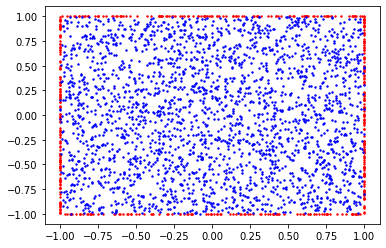

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize

from jax.config import config
config.update("jax_enable_x64", True)

Phi_ref = lambda x:  np.exp(2*x[:,0])*np.sin(2*x[:,1])/8
Rhs = lambda x: 0.0*x[:,0]
N_in = 2500
N_bd = 500
pts_inside = jnp.array(np.random.rand(N_in,2)*2-1,  dtype = jnp.float64)

tmp1 = np.random.randint(0, high=2, size=(N_bd,1))
tmp2 = np.random.randint(0, high=2, size=(N_bd,1))
xbd_train = (np.random.rand(N_bd,1)*2-1)*tmp1 + (1 - tmp1)*(tmp2*(-1)+(1-tmp2)*1)
tmp2 = np.random.randint(0, high=2, size=(N_bd,1))
ybd_train = (np.random.rand(N_bd,1)*2-1)*(1-tmp1) + tmp1*(tmp2*(-1)+(1-tmp2)*1)
pts_bd = jnp.array(np.concatenate((xbd_train[:],ybd_train[:]),1), dtype = jnp.float64)
bd_vals = Phi_ref(pts_bd)

plt.figure()
plt.scatter(pts_bd[:,0],pts_bd[:,1],c='r',s=2)
plt.scatter(pts_inside[:,0],pts_inside[:,1],c='b',s=2)




In [2]:

nn_init, nn_apply = stax.serial(
    stax.Dense(15),
    stax.Tanh,
    stax.Dense(15),
    stax.Tanh,
    stax.Dense(15),
    stax.Tanh,
    stax.Dense(15),
    stax.Tanh,
    stax.Dense(1)
)


rng = jax.random.PRNGKey(123)

weights = nn_init(rng, (-1,2))

weights = weights[1] ## Weights are actually stored in second element of two value tuple

for w in weights:
    if w:
        w, b = w
        print("Weights : {}, Biases : {}".format(w.shape, b.shape))
        
@jax.jit
def loss(weights):
    lbd = (jnp.mean((nn_apply(weights, pts_bd)[:,0] - bd_vals)**2))
    lpde = (jnp.mean((pinns.operators.laplace(lambda x: nn_apply(weights, x))(pts_inside)[:] - Rhs(pts_inside)[:])**2))
    return lbd + 0.1*lpde

N_epochs = 100000

@jax.jit
def update(params, step_size = 0.001):

    grads = jax.grad(loss)(params)
    return [() if wb==() else (wb[0] - step_size * dwdb[0], wb[1] - step_size * dwdb[1]) for wb, dwdb in zip(params, grads)]
  
weights_vector, weights_unravel = jax.flatten_util.ravel_pytree(weights)

@jax.jit
def loss_handle(w):
    ws = weights_unravel(w)
    l = loss(ws)
    return l

@jax.jit
def lossgrad_handle(w):
    ws = weights_unravel(w)
    
    l = loss(ws)
    gr = jax.grad(loss)(ws)
    gr,_ = jax.flatten_util.ravel_pytree(gr)
    return l, gr

def loss_grad(w):
    l, gr = lossgrad_handle(jnp.array(w))
    return np.array(l.to_py()), np.array(gr.to_py()) 


Weights : (2, 15), Biases : (15,)
Weights : (15, 15), Biases : (15,)
Weights : (15, 15), Biases : (15,)
Weights : (15, 15), Biases : (15,)
Weights : (15, 1), Biases : (1,)


In [3]:
print('Starting optimization')
# results = jax.scipy.optimize.minimize(loss_interface, x0 = weights_vector, method = 'bfgs', options = {'maxiter': 10})
#result = scipy.optimize.minimize(loss_grad, x0 = weights_vector.to_py(), method = 'BFGS', jac = True, tol = 1e-8, options = {'disp' : True, 'maxiter' : 400}, callback = lambda x: print(loss_handle(x)))
result = scipy.optimize.minimize(loss_grad, x0 = weights_vector.to_py(), method = 'L-BFGS-B', jac = True, tol = 1e-8, options = {'disp' : True, 'maxiter' : 1500, 'iprint': 1})
weights = weights_unravel(jnp.array(result.x))

# print('Ready')
# N_epochs = 10000
# for epoch in range(N_epochs):
#     tme = datetime.datetime.now()
#     weights = update(weights, 0.05/2)
#     tme = datetime.datetime.now() - tme
#     print()
#     print('Iteration ',epoch+1,' time ',tme, ' loss ', loss(weights))
   


Starting optimization
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          781     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51040D-01    |proj g|=  3.92328D-01

At iterate    1    f=  1.20392D-01    |proj g|=  4.74142D-02

At iterate    2    f=  1.16508D-01    |proj g|=  3.56088D-02


 This problem is unconstrained.



At iterate    3    f=  1.13028D-01    |proj g|=  3.06682D-02

At iterate    4    f=  1.07050D-01    |proj g|=  5.58231D-02

At iterate    5    f=  9.64103D-02    |proj g|=  5.54651D-02

At iterate    6    f=  8.52467D-02    |proj g|=  1.02084D-01

At iterate    7    f=  7.98873D-02    |proj g|=  4.46081D-02

At iterate    8    f=  7.83765D-02    |proj g|=  3.63891D-02

At iterate    9    f=  7.15664D-02    |proj g|=  4.67036D-02

At iterate   10    f=  6.58299D-02    |proj g|=  3.12087D-02

At iterate   11    f=  5.89564D-02    |proj g|=  5.94073D-02

At iterate   12    f=  5.61132D-02    |proj g|=  1.36282D-01

At iterate   13    f=  5.06340D-02    |proj g|=  3.05886D-02

At iterate   14    f=  4.72094D-02    |proj g|=  1.91998D-02

At iterate   15    f=  4.37037D-02    |proj g|=  3.05126D-02

At iterate   16    f=  3.80743D-02    |proj g|=  7.84415D-02

At iterate   17    f=  3.35999D-02    |proj g|=  3.06281D-02

At iterate   18    f=  3.06604D-02    |proj g|=  2.47569D-02

At iter

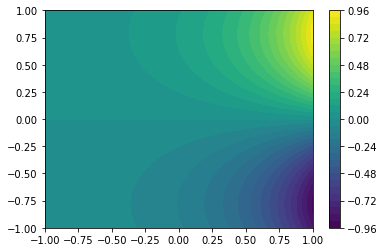

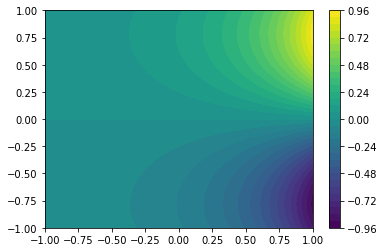

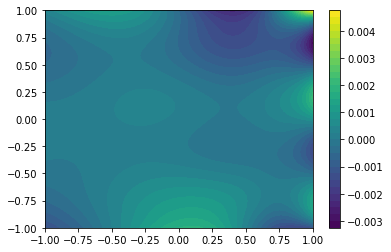

In [4]:

x,y = np.meshgrid(np.linspace(-1,1,100),np.linspace(-1,1,100))
xy = np.concatenate((x.flatten()[:,None],y.flatten()[:,None]),1)

plt.figure()
plt.contourf(x,y,nn_apply(weights,xy).reshape(x.shape), levels = 32)
plt.colorbar()

plt.figure()
plt.contourf(x,y,Phi_ref(xy).reshape(x.shape), levels = 32)
plt.colorbar()

plt.figure()
plt.contourf(x,y,nn_apply(weights,xy).reshape(x.shape) - Phi_ref(xy).reshape(x.shape), levels = 32)
plt.colorbar()

In [5]:
result.x

array([ 4.61210908e-01,  6.91308334e-01,  3.78100277e-01,  1.53002982e-01,
        1.59054764e-01,  3.20125765e-01,  2.72388219e-02, -5.57353160e-03,
       -3.28875907e-01, -5.47669342e-01,  6.45471954e-01, -3.37878234e-01,
        7.29372616e-02, -2.81550235e-01, -4.65804848e-01,  6.38102201e-02,
       -1.88034966e-01, -9.74992632e-02,  2.75827788e-01, -7.98246799e-01,
        2.20280080e-01, -3.42896491e-01,  1.81132620e-01, -3.33436752e-01,
       -2.33751574e-01,  2.11309689e-01,  9.14085390e-02,  3.05331701e-01,
        3.94139953e-01,  2.64242427e-01, -3.60948833e-01, -9.37944794e-01,
       -4.84800676e-01,  8.94321237e-02, -1.21267077e-03, -6.14301387e-01,
        3.37600173e-01,  2.53692351e-01,  7.44729445e-01,  3.35750477e-01,
       -4.28759388e-01,  5.98101233e-01,  1.78458221e-01,  1.04657940e-01,
        7.81141944e-01,  1.52356680e-01,  5.62522939e-01, -2.11880056e-01,
        2.08036287e-01,  1.28136410e-01, -2.37019589e-01,  2.57562184e-01,
       -4.86916524e-01, -